[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mitchell-Mirano/Allison/blob/develop/examples/nn/1-regression.ipynb)

In [1]:
!pip install "sorix @ git+https://github.com/Mitchell-Mirano/sorix.git@develop"

zsh:1: command not found: pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

import sorix
from sorix.nn import Relu,Linear
from sorix.optim import RMSprop
from sorix import tensor
from sorix.nn import NeuralNetwork
from sorix.nn import  MSELoss
from sorix.preprocessing import MinMaxScaler
from sorix.datasets import train_test_split
from sorix.metrics import r2_score

In [3]:
device  = 'gpu' if sorix.cuda.is_available() else 'cpu'
device = 'cpu'

✅ GPU basic operation passed
✅ GPU available: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA runtime version: 13000
CuPy version: 13.6.0


# Datos

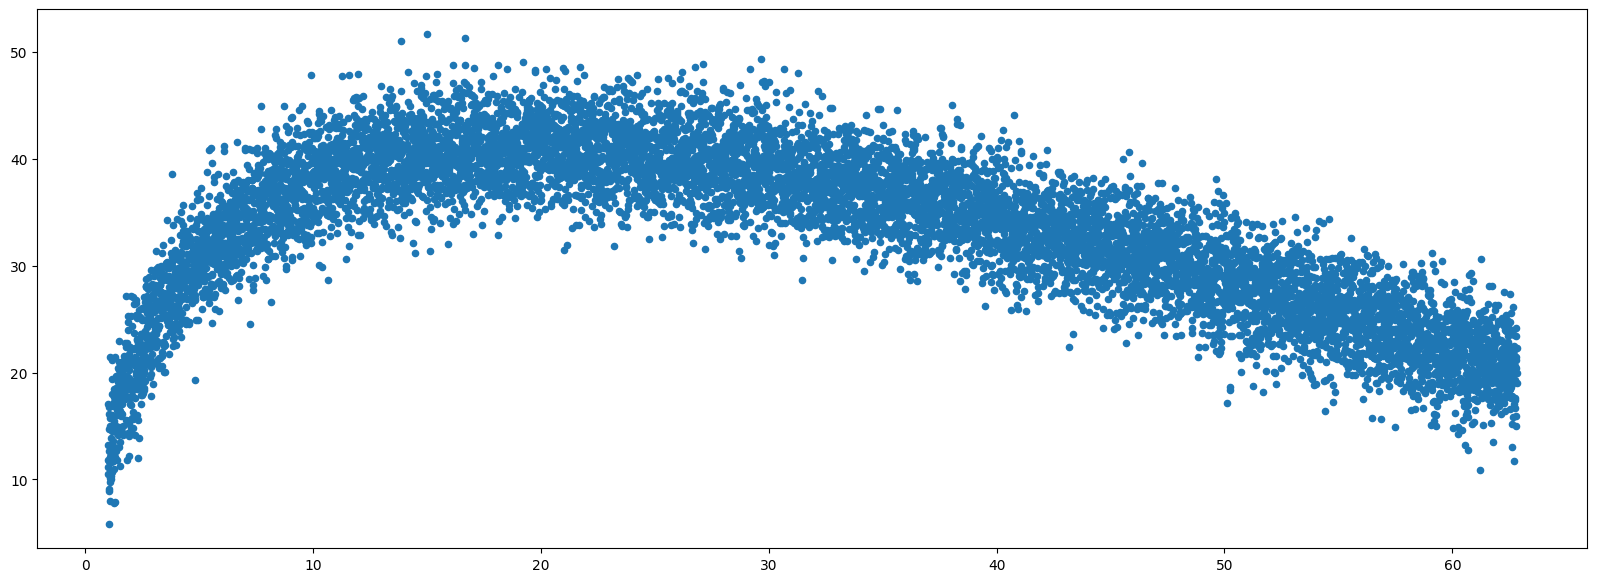

In [4]:
# Datos
points = 10000
x1 = np.linspace(1, 20*np.pi, points)
x2 = np.linspace(1, 20*np.pi, points)

# Definimos la salida
y = 20*np.log(x1+1) + -1*x2 + 3*np.random.randn(points)


data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
data.head()

plt.figure(figsize=(20,7))
plt.scatter(data['x2'], data['y'], s=20)
plt.show()


# Preprocessing

In [5]:
independent_variables = ['x1', 'x2']
dependent_variable = ['y']

In [6]:
# Train test split and normalization
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

X_train = df_train[independent_variables]
Y_train = df_train[dependent_variable]

X_test = df_test[independent_variables]
Y_test = df_test[dependent_variable]

X_train

,x1,x2
6252,39.661141,39.661141
4684,29.964936,29.964936
1731,11.704164,11.704164
4742,30.323597,30.323597
4521,28.956976,28.956976
...,...,...
1638,11.129070,11.129070
5891,37.428788,37.428788
7427,46.927110,46.927110
608,4.759753,4.759753


In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train

array([[0.62526253, 0.62526253],
       [0.46844684, 0.46844684],
       [0.17311731, 0.17311731],
       ...,
       [0.74277428, 0.74277428],
       [0.06080608, 0.06080608],
       [0.69076908, 0.69076908]], shape=(8000, 2))

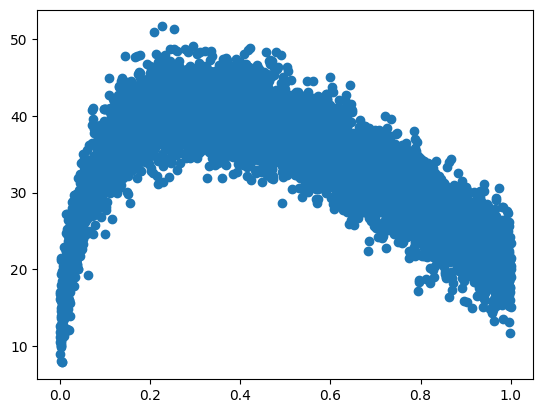

In [8]:
plt.Figure(figsize=(20,7))
plt.scatter(X_train[:,0], Y_train)
plt.show()

In [9]:
if device == 'gpu':

    X_train = tensor(X_train).to(device)
    Y_train = tensor(Y_train).to(device)

    X_test = tensor(X_test).to(device)
    Y_test = tensor(Y_test).to(device)
else:
    X_train = tensor(X_train)
    Y_train = tensor(Y_train)

    X_test = tensor(X_test)
    Y_test = tensor(Y_test)

print(f"X_train shape: {X_train.shape}, device: {X_train.device}")
print(f"Y_train shape: {Y_train.shape}. device: {Y_train.device}")
print(f"X_test shape: {X_test.shape}, device: {X_test.device}")
print(f"Y_test shape: {Y_test.shape}, device: {Y_test.device}")

X_train shape: (8000, 2), device: cpu
Y_train shape: (8000, 1). device: cpu
X_test shape: (2000, 2), device: cpu
Y_test shape: (2000, 1), device: cpu


In [10]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 64)
        self.relu = Relu()
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, x: tensor) -> tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    

if device == 'gpu':
    net = Network().to(device)
else:
    net = Network()

In [11]:
criterion = MSELoss()
optimizer = RMSprop(net.parameters(), lr=1e-2)

In [12]:
Y_pred = net(X_train)
Y_pred

Tensor(
[[0.64082439]
 [0.4801058 ]
 [0.17742595]
 ...
 [0.76126084]
 [0.06231945]
 [0.7079613 ]], shape=(8000, 1), device=cpu, requires_grad=True)

In [13]:
# %%
# Bucle de entrenamiento mejorado
for epoch in range(100 + 1):
    Y_pred = net(X_train)
    loss = criterion(Y_train,Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        r2_train = r2_score(Y_pred, Y_train)
        with sorix.no_grad():
            Y_pred = net(X_test)
            r2_test = r2_score(Y_test, Y_pred)
        print(f"[{device}] Epoch {epoch:5d} | Loss: {loss.item():.4f} | R2_Train: {100*r2_train:5.2f} % | R2_Test: {100*r2_test:5.2f} %")
        if r2_test > 0.95:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break

[cpu] Epoch     0 | Loss: 1142.1440 | R2_Train: -1303647.65 % | R2_Test: -1789.38 %
[cpu] Epoch    10 | Loss: 331.0987 | R2_Train: -141.98 % | R2_Test: -513.24 %
[cpu] Epoch    20 | Loss: 272.5142 | R2_Train: -140.64 % | R2_Test: -401.71 %
[cpu] Epoch    30 | Loss: 191.4945 | R2_Train: -184.16 % | R2_Test: -243.67 %
[cpu] Epoch    40 | Loss: 104.0949 | R2_Train: -392.67 % | R2_Test: -84.41 %
[cpu] Epoch    50 | Loss: 55.1578 | R2_Train: -15036.68 % | R2_Test: -1.43 %
[cpu] Epoch    60 | Loss: 44.0526 | R2_Train: -1304.21 % | R2_Test: 18.46 %
[cpu] Epoch    70 | Loss: 41.0433 | R2_Train: -494.84 % | R2_Test: 23.12 %
[cpu] Epoch    80 | Loss: 38.9939 | R2_Train: -355.71 % | R2_Test: 27.06 %
[cpu] Epoch    90 | Loss: 37.4184 | R2_Train: -303.53 % | R2_Test: 30.09 %
[cpu] Epoch   100 | Loss: 35.9002 | R2_Train: -265.56 % | R2_Test: 32.77 %


Text(0.5, 1.0, 'Polinomic Regression on Test Data(Accuracy:32.77%)')

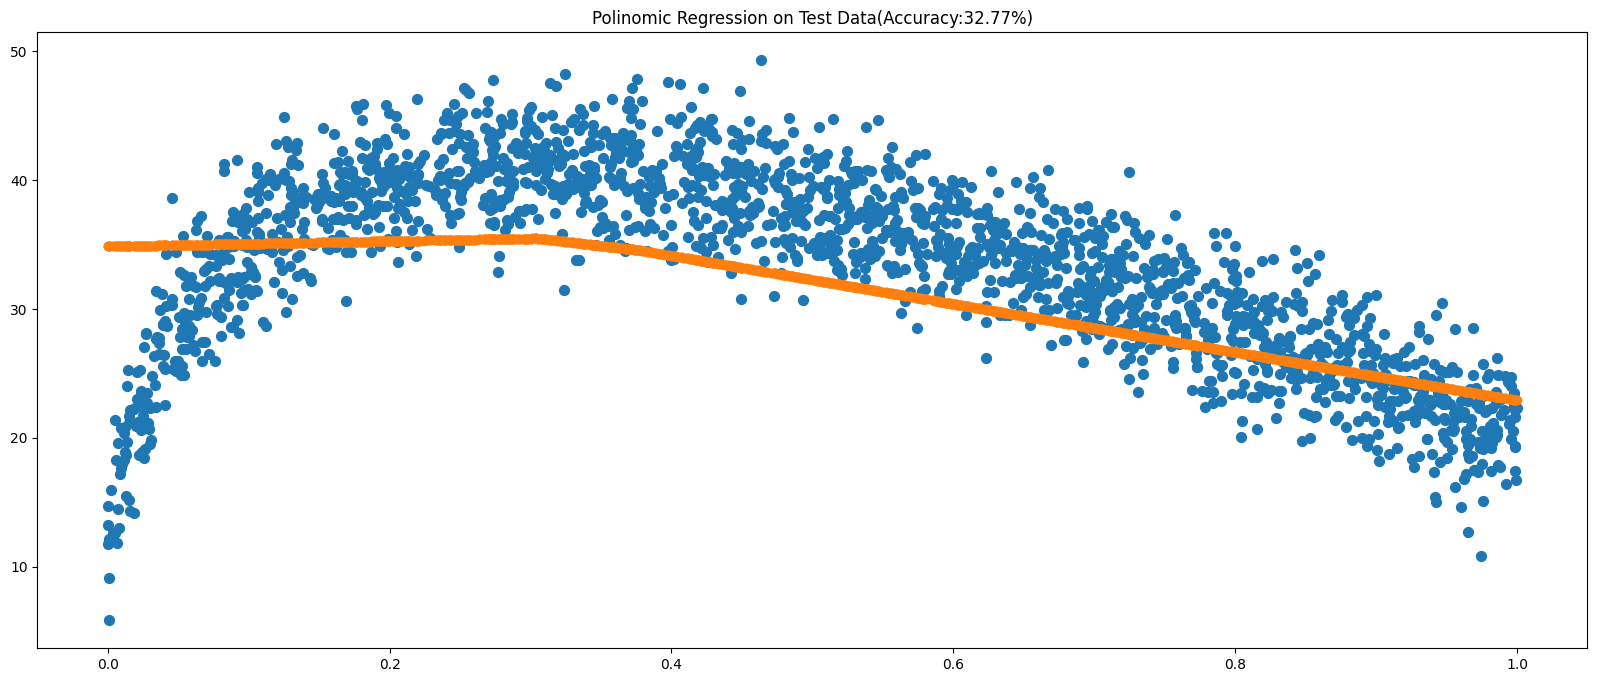

In [14]:
# %%
# Visualización final

with sorix.no_grad():
    y_pred = net(X_test)

r2 = r2_score(Y_test, y_pred)

plt.figure(figsize=(20,8))
plt.scatter(X_test.to('cpu')[:,0].data,Y_test.to('cpu').data,s=50)
plt.scatter(X_test.to('cpu')[:,0].data,y_pred.to('cpu').data)
plt.title(f'Polinomic Regression on Test Data(Accuracy:{r2*100:.2f}%)')

# Save and Load Model

In [15]:
import joblib

In [16]:
joblib.dump(net.weights(), 'regression_weights.joblib')

['regression_weights.joblib']

# CPU

In [17]:
net2 = Network()
net2.load_weights(joblib.load('regression_weights.joblib'))

if X_test.device == 'cpu':
    out = net2(X_test)
if X_test.device == 'gpu':
    out = net2(X_test.to('cpu'))

out

Tensor(
[[34.93261411]
 [28.05844004]
 [29.6317638 ]
 ...
 [31.5324736 ]
 [35.02683592]
 [28.01541216]], shape=(2000, 1), device=cpu, requires_grad=True)

# GPU

In [18]:
net2 = Network()
net2.load_weights(joblib.load('regression_weights.joblib'))
net2.to('gpu')

if X_test.device == 'cpu':
    out = net2(X_test.to('gpu'))
if X_test.device == 'gpu':
    out = net2(X_test)

out

Tensor(
[[34.93261411]
 [28.05844004]
 [29.6317638 ]
 ...
 [31.5324736 ]
 [35.02683592]
 [28.01541216]], shape=(2000, 1), device=gpu, requires_grad=True)